In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

root_path = 'gdrive/My Drive/Colab Notebooks/'
print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/Colab Notebooks/


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers, optimizers, datasets
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics
import seaborn as sn 
import pandas as pd
import idx2numpy
import random

In [ ]:
print(tf.__version__)
print('num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

2.8.2
num GPUs Available:  1


**DATA LOADING & PREPROCESSING**

In [ ]:
# load mnist data
(DATA_TRAIN, TRAIN_LABEL), (DATA_TEST, TEST_LABEL) = datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
print("Dimension of training data: ", DATA_TRAIN.shape)
print("Dimension of test data: ",DATA_TEST.shape)
print("Training label: ", np.unique(TRAIN_LABEL))
num_classes = len(np.unique(TRAIN_LABEL))

Dimension of training data:  (60000, 28, 28)
Dimension of test data:  (10000, 28, 28)
Training label:  [0 1 2 3 4 5 6 7 8 9]


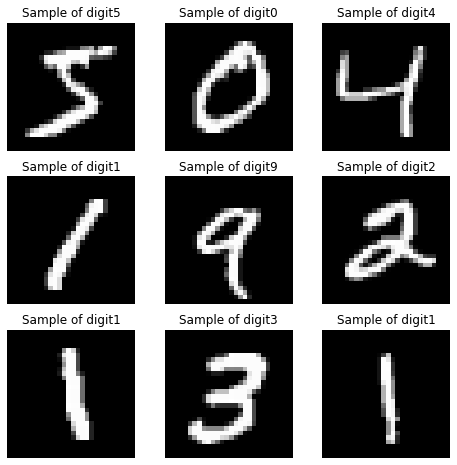

In [ ]:
# plot some samples
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(DATA_TRAIN[i], cmap="gray")
    plt.title("Sample of digit" + str(TRAIN_LABEL[i]))
    plt.axis("off")

In [ ]:
# normalize image pixel value
DATA_TRAIN_NORM = DATA_TRAIN.astype("float32")/255
DATA_TEST_NORM = DATA_TEST.astype("float32")/255

print("Dimension of training data: ", DATA_TRAIN_NORM.shape)
print("Dimension of test data: ", DATA_TEST_NORM.shape)

Dimension of training data:  (60000, 28, 28)
Dimension of test data:  (10000, 28, 28)


In [ ]:
# Convert a 28 x 28 image into a 784 x 1 vector
x_train_mlp = DATA_TRAIN_NORM.reshape([DATA_TRAIN_NORM.shape[0],
                               DATA_TRAIN_NORM.shape[1]*DATA_TRAIN_NORM.shape[2]])
x_test_mlp = DATA_TEST_NORM.reshape([DATA_TEST_NORM.shape[0],
                             DATA_TEST_NORM.shape[1]*DATA_TEST_NORM.shape[2]])

print("Dimension of training data: ", x_train_mlp.shape)
print("Dimension of test data: ", x_test_mlp.shape)

Dimension of training data:  (60000, 784)
Dimension of test data:  (10000, 784)


In [ ]:
x_train_cnn = DATA_TRAIN_NORM.reshape(60000, 28, 28, 1)
x_test_cnn = DATA_TEST_NORM.reshape(10000, 28, 28, 1)

print("Dimension of training data: ", x_train_cnn.shape)
print("Dimension of test data: ", x_test_cnn.shape)

Dimension of training data:  (60000, 28, 28, 1)
Dimension of test data:  (10000, 28, 28, 1)


In [ ]:
# convert label to categorical
y_train = keras.utils.to_categorical(TRAIN_LABEL, num_classes)
y_test = keras.utils.to_categorical(TEST_LABEL, num_classes)

print("Example :")
print("Label before conversion: ", TRAIN_LABEL[0])
print("Label after conversion: ", y_train[0])


Example :
Label before conversion:  5
Label after conversion:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


**MODELLING MLP**

In [ ]:
input_shape = (x_train_mlp.shape[1],)
model = keras.Sequential([
    Dense(units=512, activation='relu', input_shape=input_shape),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def model_builder(hp):
  model = keras.Sequential([
    Dense(units=512, activation='relu', input_shape=input_shape),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=num_classes, activation='softmax')])
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.categorical_crossentropy,
                metrics = ['accuracy'])
  return model
tuner = kt.Hyperband(model_builder,
                      objective='val_accuracy',
                      max_epochs = 10,
                      factor = 3,
                      directory = 'my_dir',
                      project_name = 'MLP')


In [ ]:
tuner.search(x_train_mlp, y_train, epochs=10, validation_split=0.2)

# Get the optimal hyperparamaters
best_hps = tuner.get_best_hyperparameters(num_trials=2)[0]
print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer 
is {best_hps.get('learning_rate')}.
""")

Trial 4 Complete [00h 00m 11s]
val_accuracy: 0.9109166860580444

Best val_accuracy So Far: 0.965583324432373
Total elapsed time: 00h 01m 43s

The hyperparameter search is complete. The optimal learning rate for the optimizer 
is 0.001.



In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_mlp, y_train, epochs=10, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
1500/1500 [==============================] - 6s 3ms/step - loss: 0.2151 - accuracy: 0.9346 - val_loss: 0.1197 - val_accuracy: 0.9620
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0943 - accuracy: 0.9706 - val_loss: 0.0976 - val_accuracy: 0.9708
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0644 - accuracy: 0.9799 - val_loss: 0.0859 - val_accuracy: 0.9742
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0482 - accuracy: 0.9852 - val_loss: 0.0892 - val_accuracy: 0.9765
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0408 - accuracy: 0.9873 - val_loss: 0.0816 - val_accuracy: 0.9772
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0321 - accuracy: 0.9898 - val_loss: 0.1014 - val_accuracy: 0.9751
Epoch 7/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0293 - accuracy: 0.9908 - val_loss: 0.0986 - val_accuracy:

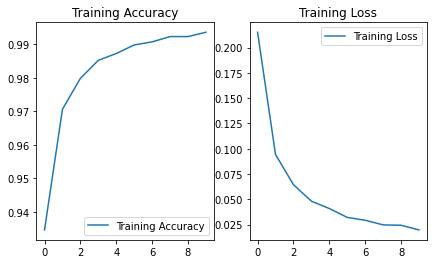

In [ ]:
# Get training statistics
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy]
loss = history.history['loss']
# val_loss = history.history['val_loss]

epochs_range = range(10)

# plot training result
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
# plt.plot(epocsh_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.show()

In [ ]:
score = model.evaluate(x_test_mlp, y_test, verbose=1)
print('Test loss: ', score[0])
print('Test Accuracy: ', score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.1005 - accuracy: 0.9769
Test loss:  0.10045350342988968
Test Accuracy:  0.9768999814987183


In [ ]:
prediction = tf.argmax(model.predict(x_test_mlp),1).numpy()
report = metrics.classification_report(TEST_LABEL, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.99      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.99      0.96      0.98       982
           5       0.97      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.96      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



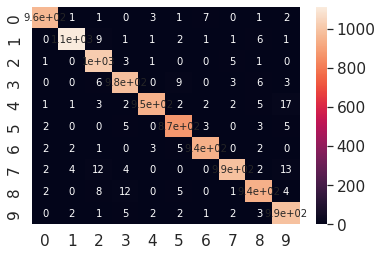

In [ ]:
cf = tf.math.confusion_matrix(TEST_LABEL, prediction).numpy()
df_cm = pd.DataFrame(cf, range(10), range(10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size":10})
plt.show()

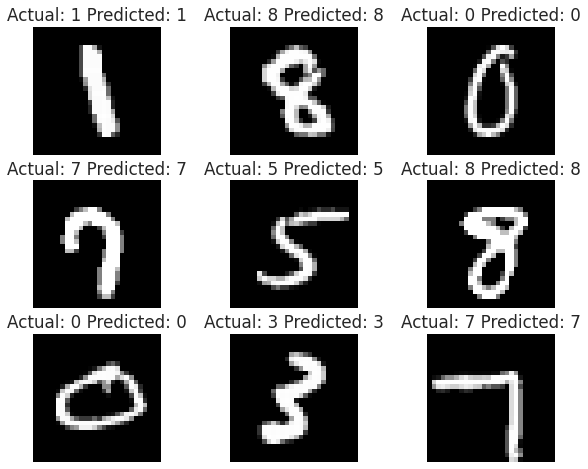

In [ ]:
# plot some samples
sample = random.sample(range(1, TEST_LABEL.shape[0]), 9)
plt.figure(figsize=(10,8))
n=0
for i in sample:
    plt.subplot(3,3,n+1)
    plt.imshow(DATA_TEST[i], cmap='gray')
    plt.title("Actual: " + str(TEST_LABEL[i]) +" Predicted: " + str(prediction[i]))
    plt.axis("off")
    n+=1

**MODELLING CNN**

In [ ]:
input_shape1 = (28,28,1)
model1 = keras.Sequential() # Create a network sequence

# Add the first convolutional layer and pooling layer
model1.add(Conv2D(filters=32, kernel_size=5, strides=(1,1), padding="same", activation="relu", input_shape=input_shape1))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid"))

# Add the second convolutional layer and pooling layer
model1.add(Conv2D(filters=64, kernel_size=3, strides=(1,1), padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding="valid"))

In [ ]:
# Add a dropout layer to reduce overfitting
model1.add(Dropout(0.25))
model1.add(Flatten())
# model1.add(GlobalAveragePooling2D())
# model1.add(GlobalMaxPooling2D())
# Add two fully connected layers
model1.add(Dense(units=128, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(units=10, activation="softmax"))

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)             

In [ ]:
def model_builder_cnn(hp):
  model1 = keras.Sequential() # Create a network sequence.
# Add the first convolutional layer and pooling layer.
  model1.add(Conv2D(filters=32, kernel_size=5, strides=(1,1), padding="same", activation="relu", input_shape=input_shape1))
  model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding = "valid"))
# Add the second convolutional layer and pooling layer.
  model1.add(Conv2D(filters=64, kernel_size=3, strides=(1,1), padding="same", activation="relu"))
  model1.add(MaxPool2D(pool_size=(2,2), strides =(2,2), padding="valid"))
# Add a dropout layer to reduce overfitting.
  model1.add(Dropout(0.25))
  model1.add(Flatten())
# model1.add(GlobalAveragePooling2D())
# model1.add(GlobalMaxPooling2D())
# Add two fully connected layers.
  model1.add(Dense(units=128, activation="relu"))
  model1.add(Dropout(0.5))
  model1.add(Dense(units=10, activation="softmax"))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4,1e-5])
  model1.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                 loss=keras.losses.categorical_crossentropy,
                 metrics=['accuracy'])
  return model1
tuner = kt.Hyperband(model_builder_cnn,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='CNN')
tuner.search(x_train_cnn, y_train, epochs=10, validation_split=0.2)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=2)[0]
print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.0001.



In [ ]:
 model1 = tuner.hypermodel.build(best_hps)
history = model1.fit(x_train_cnn, y_train, epochs=10, validation_split=0.2)
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
1500/1500 [==============================] - 16s 4ms/step - loss: 0.5744 - accuracy: 0.8248 - val_loss: 0.1477 - val_accuracy: 0.9594
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1926 - accuracy: 0.9435 - val_loss: 0.0951 - val_accuracy: 0.9724
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1359 - accuracy: 0.9602 - val_loss: 0.0731 - val_accuracy: 0.9782
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1112 - accuracy: 0.9668 - val_loss: 0.0639 - val_accuracy: 0.9809
Epoch 5/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0942 - accuracy: 0.9720 - val_loss: 0.0542 - val_accuracy: 0.9842
Epoch 6/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0801 - accuracy: 0.9759 - val_loss: 0.0521 - val_accuracy: 0.9853
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0730 - accuracy: 0.9776 - val_loss: 0.0467 - val_accurac

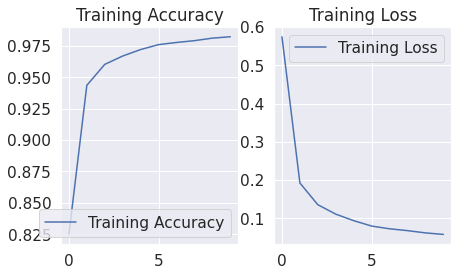

In [ ]:
# get training statistics
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss=history.history['loss']
# val_loss=history.history['val_loss']

epochs_range = range(10)

# plot training result
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [ ]:
score = model1.evaluate(x_test_cnn, y_test, verbose=1)
print('Test loss: ', score[0])
print('Test Accuracy: ', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0285 - accuracy: 0.9900
Test loss:  0.028535131365060806
Test Accuracy:  0.9900000095367432


In [ ]:
prediction=tf.argmax(model1.predict(x_test_cnn),1).numpy()
report = metrics.classification_report(TEST_LABEL, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



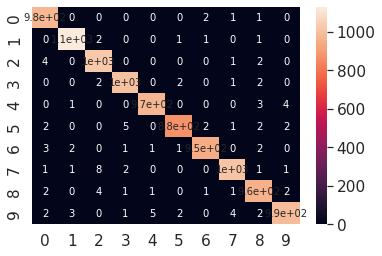

In [ ]:
cf = tf.math.confusion_matrix(TEST_LABEL, prediction).numpy()
df_cm = pd.DataFrame(cf, range(10), range(10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size":10})
plt.show()

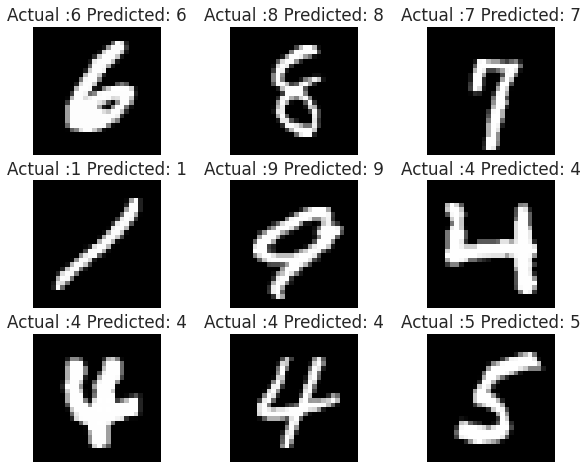

In [ ]:
 # plot some samples
sample=random.sample(range(1, TEST_LABEL.shape[0]), 9)
plt.figure(figsize=(10,8))
n=0
for i in sample:
  plt.subplot(3,3,n+1)
  plt.imshow(DATA_TEST[i], cmap="gray")
  plt.title("Actual :" + str(TEST_LABEL[i]) +" Predicted: " + str(prediction[i]))
  plt.axis("off")

  n+=1

In [ ]:
# save temporary in google colab drive
model.save('./model.h5')

model_path = os.path.join(root_path + 'model/final_CNN_model.h5')
model.save(model_path)